# Juliaで動かす金融計算-コールオプションの計算編

簡単なデリバティブの例として, 先渡を計算しました.  
ここでは, 本講座の集大成として, より複雑なデリバティブである, コールオプションの現在価値の計算にトライしてみましょう.

## コールオプションって？

（ヨーロピアン）コールオプションとは, 決められた日（満期日と言います）に, 決められた価格（ストライクと言います）で, 原資産（ここでも株としましょう）を買う**権利**のことです.  
なんだか先渡と似ていますが, 先渡が買う**義務**であったのに対して, オプションは**権利**であるところです.  
権利であるので, 買うかどうかは満期日に選ぶことができるのが特徴です.  
このオプションを買うと, 満期日のお金の動きはどうなるのでしょうか？ 詳しく見ていきましょう.

## コールオプションのペイオフ

### ペイオフの考察

ある金融商品を買ったときに, それがもたらす損益のことを「ペイオフ」と言ったりします.  
ここでは, コールオプションのペイオフ, つまり, 満期日にいくらの利益を得ることができるかを見ていきましょう.  
例として, ストライクが120円の場合を考えてみましょう.  
![option_payoff.png](..\\Figs\\option_payoff.png)  
上図のように, 満期日の株価によって, 権利行使したほうがお得なのか, 権利放棄したほうがお得なのかが変わるため, **ペイオフの式が満期日の株価によって変わる**ことがわかるかと思います.  

【コールオプションのペイオフ】
* 満期日の株価 $\geq$ ストライクの場合...ペイオフ = 満期日の株価 - ストライク
* 満期日の株価 $\leq$ ストライクの場合...ペイオフ = 0

先渡の計算の時は, ペイオフの式が満期日の株価によって変わるなんてことはありませんでした.   

【先渡しのペイオフ】  
ペイオフ = 満期日の株価 - 先渡価格  

コールオプションの計算の難しさの理由がこれです.

### ペイオフダイアグラム

さて, 先ほど確認したペイオフについて, グラフを書くことで確認しておきましょう.  
横軸に株価, 縦軸にペイオフをとってグラフにしたものを**ペイオフダイアグラム**と言います.  
それではペイオフダイアグラムを書いてみましょう.

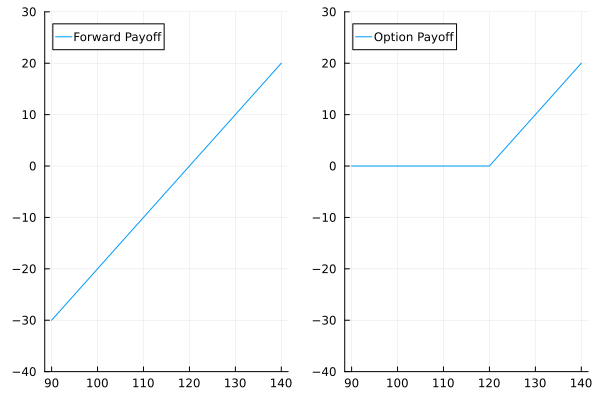

In [4]:
using Plots

function PlotPayoffDiagram()
    s = 90:5:140 #5円刻みで株価を生成
    K = 120 #ストライクを設定

    #先渡のペイオフの計算
    calcForwardPayoff = (s) -> s - K
    
    #オプションのペイオフの計算
    calcOptionPayoff = (s) -> begin
        if s ≥ K
            s - K
        else
            0
        end
    end

    yrange = (-40, 30) #縦軸の範囲を指定
    p1 = plot(s, calcForwardPayoff, yrange = yrange, label = "Forward Payoff")
    p2 = plot(s, calcOptionPayoff, yrange = yrange, label = "Option Payoff")

    plot(p1, p2)
end

PlotPayoffDiagram()

ペイオフダイアグラムが表示されたでしょうか.  
ペイオフダイアグラムを見てみても, 明らかに先渡の時とは異なるペイオフになっていることが確認できるかと思います.

## コールオプションの現在価値計算

満期日の株価によって, コールオプションのペイオフの計算式が変わることを見てきました.  
さて, コールオプションの現在価値, つまり理論価格はどうやって計算すればよいでしょうか？ 先渡のところで考えたことを基に, 考えてみましょう.  
先渡の計算の時には, **ペイオフを割り引いて**考えました. まずは, 素朴にこれと同じことができないかを考えてみましょう.  
コールオプションのペイオフにディスカウントファクターをかけて現在価値を求めようとすると, すぐに困ることがあります.  
それは, 満期日の株価が決定できない（確率的に動く）ので, 将来のペイオフの計算式が確定しません. つまり, 割り引くべき値が確定しないのです.  
そこで, **将来のペイオフの平均値（=期待値）を割り引いたものを現在価値とする**と考えてみましょう. つまり, **「将来, 平均的にこれくらいの利益が得られるから, それを割り引いて現在価値にしてしまおう」** という発想です.  

$$
    コールオプションの理論価格 = ディスカウントファクター \times 将来のペイオフの平均値
$$

この方法なら, 将来のペイオフの平均値（=期待値）を計算できれば, コールオプションの現在価値の計算ができます.  
問題は, どうやって将来のペイオフの平均値を計算するかですが, ここでプログラミングの出番です.  
今までやってきた, 株価のシミュレーションを使って, 満期日の株価をシミュレーションして, その時のペイオフを計算することを繰り返せば, ペイオフの平均値が計算できます.
このことをまとめておきましょう.  

【コールオプションの現在価値の求め方】
1. 満期日の株価をシミュレーションする
1. コールオプションのペイオフを計算する
1. 1-2を繰り返す
1. コールオプションのペイオフの平均値を求める
1. ディスカウントファクターを使って割り引く

## コールオプションの現在価値計算の実装

それでは, 前述の流れに従って, コードを書いてみましょう.  
まずは, コールオプションのペイオフを計算する関数を作っておきます.

In [1]:
function CalcCallOptionPayoff(S, K)
    if S ≥ K
        S - K
    else
        0
    end
end

CalcCallOptionPayoff (generic function with 1 method)

シミュレーション結果（コールオプションの価格）：3.1262581821939635


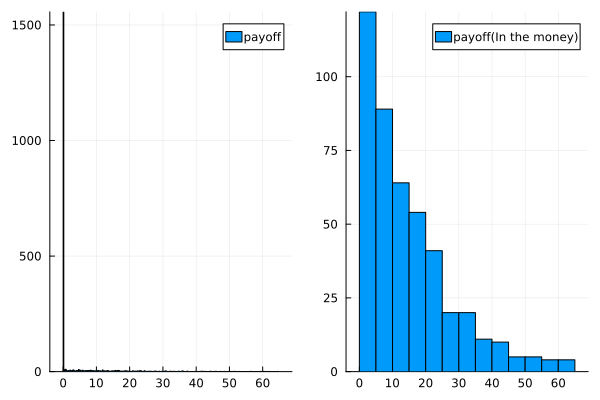

In [22]:
using Distributions
using StatsPlots

function CalcCallOptionPayoff(S, K)
    if S ≥ K
        S - K
    else
        0
    end
end

#時刻Tの価値を時刻tの価値にするディスカウントファクターの計算をする関数
#rは金利
function CalcDiscountFactor(r, T, t)
    return exp(-r * (T - t))
end

function SimulateCallOptionPrice(n) #nは何回ペイオフを計算するか.
    #1.定数の設定
    T = 1
    Δt = 0.01
    #μ = 0.5
    r = 0.05
    σ = 0.2
    S0 = 100.0#初期株価
    K = 120#ストライクの設定

    #2.時間の生成
    t = 0:Δt:T

    #3.正規分布を生成
    d = Normal(0, Δt^0.5)

    payoff = []
    for i in 1:n
        #4.初期設定
        S = [S0]

        #5.時間ごとに株価を生成
        for t_i in t[2:end]
            constantDiff = r * Δt * S[end] #確定的な変動（こっそりμ⇒rになってる！）
            w = rand(d) #乱数生成
            randomDiff = σ * w * S[end] #ランダムな変動
            nextS = S[end] + constantDiff  + randomDiff #次の株価を計算
            push!(S, nextS) #次の株価を配列に格納
        end

        nextPayoff = CalcCallOptionPayoff(S[end], K)
        push!(payoff, nextPayoff)
    end

    #平均値の割引
    df = CalcDiscountFactor(r, T, 0)
    callOptionValue = df * mean(payoff)

    #結果表示
    println("シミュレーション結果（コールオプションの価格）：", callOptionValue)

    #グラフのプロット
    h1 = histogram(payoff, label = "payoff") #ペイオフのヒストグラム
    h2 = histogram(filter(x -> x > 0, payoff), label = "payoff(In the money)") #ペイオフが正（インザマネー）のヒストグラム
    plot(h1, h2)

end

SimulateCallOptionPrice(2000)

シミュレーションの結果求めたコールオプションの価格と, ペイオフが実際どんな感じなのかが表示されたと思います.  
少し, コードについて補足説明をしておきましょう.  
まず, 株価をシミュレーションする際に, $\mu$を$r$に置き換えた件についてです.  
これは, 「将来のペイオフの平均値を割引く」という方法をとった, 代償のようなものと考えていただければと思います.  
（数学的な背景があって, それを知ると納得できるのですが, いかんせんそれが中々難しいのです.）  
次に`filter()`についてです. そういえばこれを説明していませんでしたね.  
これは, 配列等から条件を満たすものだけを取り出すための関数です(名前のままですね).  
`C#`で言うところの`Select()`みたいなものだと思っていただければ, 話が早いかと.  
今回のコードでは, これを使ってインザマネーのペイオフだけを抽出して, ヒストグラムを書いています.  
**インザマネーというのは, 権利を行使したほうが得な状態**のことを言います. **逆はアウトオブザマネー**といいます.  
ぜひこの機会に覚えておいてください.

さて, このオプションのシミュレーションについても, 色々と数値を変えて遊んでみてください.  

## （発展的事項）コールオプションの理論価格とシミュレーションの結果比較

さて, 株価をシミュレーションすることで, オプションの価格を計算しましたが, 実はオプションの理論価格を与えてくれる計算式が存在します.  
それを使うと, 今回のように株価をシミュレーションすることなく, オプションの理論価格が求まります.  
その計算式の名前を「ブラックショールズ公式」といいます.  
ブラックショールズ公式では, 以下のようにしてオプションの理論価格を求めることができます.

``` Julia
using Distributions

function BlackSholesFormula(S0, K, T, r, σ)
    d = Normal(0, 1)
    d1 = (log(S0/K) + (r + σ^2/2.0) * T)/(σ * √T)
    d2 = d1 - σ * √T

    return S0 * cdf(d, d1) - K * exp(-r * T) * cdf(d, d2)
end
```

なぜブラックショールズ公式で, コールオプションの理論価格が求まるかについての説明は割愛しますが, 上に示した関数で, コールオプションの理論価格を求めることができます.  
もし, 余裕があれば, この関数を実装し, 株価をシミュレーションして求めた結果と比較してみるとよいでしょう.  
（株価のシミュレーションによる計算結果と, 理論価格が意外と合わないことに気づくかと思います.）